# EDA

In [1]:
from src.loaders.data_loader import load_train_data

df = load_train_data()
df.head()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.08,-12,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

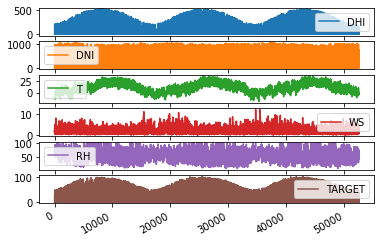

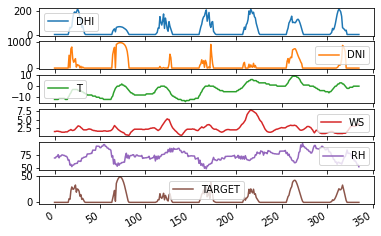

In [2]:
plot_cols = ["DHI", "DNI", "T", "WS", "RH", "TARGET"]
plot_features = df[plot_cols]
plot_features.plot(subplots=True)

plot_features = df[plot_cols][:48 * 7]
plot_features.plot(subplots=True)

In [3]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Day,52560.0,547.000000,316.102148,0.00,273.0000,547.0,821.00000,1094.000000
Hour,52560.0,11.500000,6.922252,0.00,5.7500,11.5,17.25000,23.000000
Minute,52560.0,15.000000,15.000143,0.00,0.0000,15.0,30.00000,30.000000
DHI,52560.0,64.344121,103.897125,0.00,0.0000,0.0,87.00000,528.000000
DNI,52560.0,234.792371,349.684583,0.00,0.0000,0.0,469.00000,1059.000000
WS,52560.0,2.456033,1.426874,0.00,1.4000,2.2,3.20000,12.000000
RH,52560.0,56.793102,22.052875,7.59,39.6975,57.6,72.77000,100.000000
T,52560.0,9.279928,10.179741,-19.00,1.0000,9.0,17.00000,35.000000
TARGET,52560.0,17.790630,25.759955,0.00,0.0000,0.0,32.08989,99.913939


# Feature engineering start


Hour to signal

<AxesSubplot:>

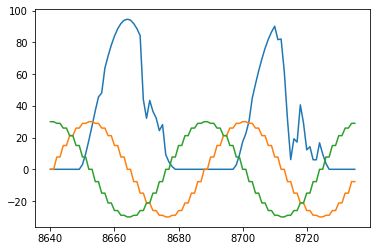

In [4]:
import numpy as np
ONE_DAY = 48
i = 180
START_DAY = ONE_DAY * i
df['Hour sin'] = 30 * np.sin(df['Hour'] * (2 * np.pi) / 24)
df['Hour cos'] = 30 * np.cos(df['Hour'] * (2 * np.pi) / 24)
df['TARGET'][START_DAY:START_DAY + ONE_DAY * 2].plot()
df['Hour sin'][START_DAY:START_DAY + ONE_DAY * 2].plot()
df['Hour cos'][START_DAY:START_DAY + ONE_DAY * 2].plot()

fourier transform

3.0 [0.00000000e+00 3.33333333e-01 6.66666667e-01 ... 8.75933333e+03
 8.75966667e+03 8.76000000e+03]


Text(0.5, 0, 'Frequency (log scale)')

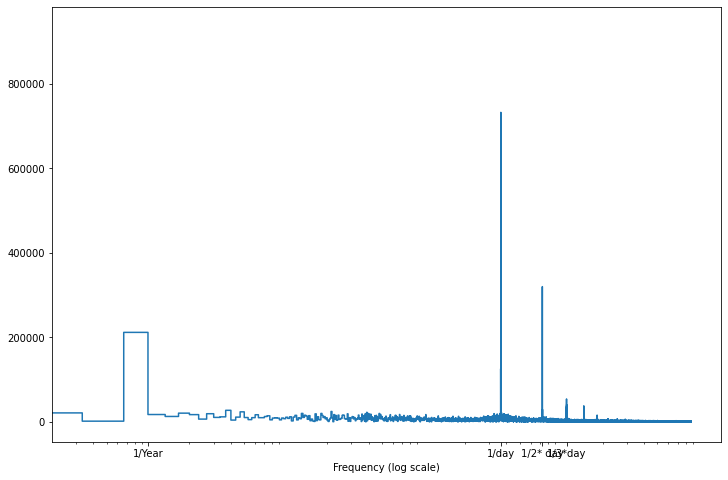

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
fft = tf.signal.rfft(df["TARGET"])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df["TARGET"])
hours_per_year = 48 * 365
years_per_dataset = n_samples_h/hours_per_year

plt.figure(figsize=(12, 8))
f_per_year = f_per_dataset/years_per_dataset
print(years_per_dataset, f_per_year)
plt.step(f_per_year, np.abs(fft))
plt.xscale("log")
plt.xticks([1, 365, 2 * 365, 3 * 365], labels=["1/Year", "1/day", "1/2* day", "1/3*day"])
plt.xlabel("Frequency (log scale)")

In [6]:
fft = tf.signal.rfft(df["TARGET"])
print(fft)

tf.Tensor(
[ 9.3507550e+05   +0.j      -2.0558285e+04+6624.996j
 -2.0182683e+03 +386.26154j ... -2.3478540e+02  +78.92418j
  1.1007031e+02 -303.19775j  3.2509375e+02   +0.j     ], shape=(26281,), dtype=complex64)


# Split datasets

In [7]:
n = len(df)
train_df = df[:int(n * 0.7)]
valid_df = df[int(n * 0.7):int(n * 0.9)]
test_df = df[int(n * 0.9):]

# Normalization

In [8]:
train_mean = train_df.mean()
train_std = train_df.std()

scaled_train_df = (train_df - train_mean) / train_std
scaled_valid_df = (valid_df - train_mean) / train_std
scaled_test_df = (test_df - train_mean) / train_std

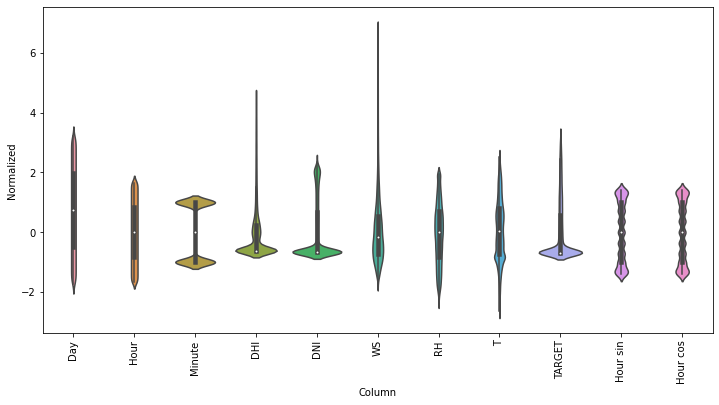

In [9]:
import seaborn as sns
scaled_df = (df - train_mean) / train_std
scaled_df = scaled_df.melt(var_name="Column", value_name="Normalized")
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x="Column", y="Normalized", data=scaled_df)
_ = ax.set_xticklabels(df.keys(), rotation=90)

# 단일 시간 입력 단일 시간 출력
### input: t, output: t + 1

In [11]:
from src.loaders.window_generator import WindowGenerator

w2 = WindowGenerator(
    train_df=train_df,
    valid_df=valid_df,
    test_df=test_df,
    input_width=24,
    label_width=1,
    shift=1,
    label_columns=["TARGET"]
)

w2


            Total window size: 25
            Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
            Label indices: [24]
            Label column name(s): ['TARGET']
        

In [12]:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 25, 11)
Inputs shape: (3, 24, 11)
labels shape: (3, 1, 1)


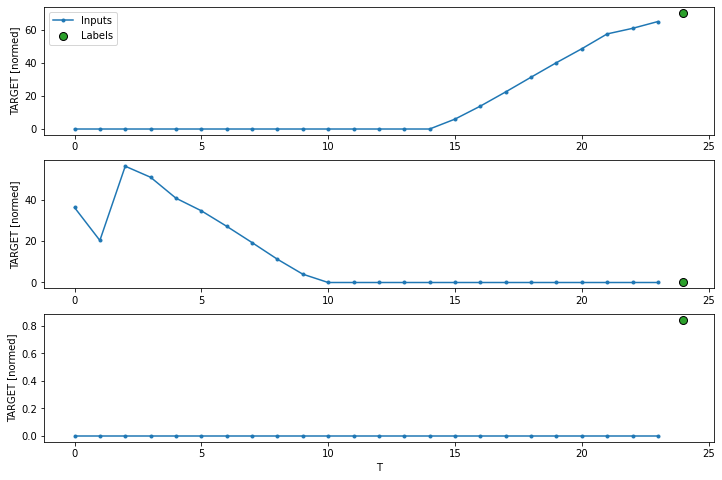

In [13]:
w2.plot()

In [14]:
single_step_window = WindowGenerator(
    train_df=train_df,
    valid_df=valid_df,
    test_df=test_df,
    input_width=1,
    label_width=1,
    shift=1,
    label_columns=["TARGET"]
)
single_step_window


            Total window size: 2
            Input indices: [0]
            Label indices: [1]
            Label column name(s): ['TARGET']
        

In [15]:
wide_window = WindowGenerator(
    train_df,
    valid_df,
    test_df,
    input_width=48,
    label_width=48,
    shift=1,
    label_columns=["TARGET"]
)

wide_window


            Total window size: 49
            Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
            Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
            Label column name(s): ['TARGET']
        

In [16]:
from src.model.single.baseline import Baseline
from src.model.loss import pinball_loss

column_indices = {name: i for i, name in enumerate(df.columns)}
baseline = Baseline(label_index=column_indices["TARGET"])

baseline.compile(loss=pinball_loss(0.1),
                 metrics=[pinball_loss(0.1), tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance["Baseline"] = baseline.evaluate(single_step_window.valid)
performance["Baseline"] = baseline.evaluate(single_step_window.test, verbose=0)

329/329 [==============================] - 1s 2ms/step - loss: 2.6555 - _pinball_loss: 2.6555 - mean_absolute_error: 5.2533

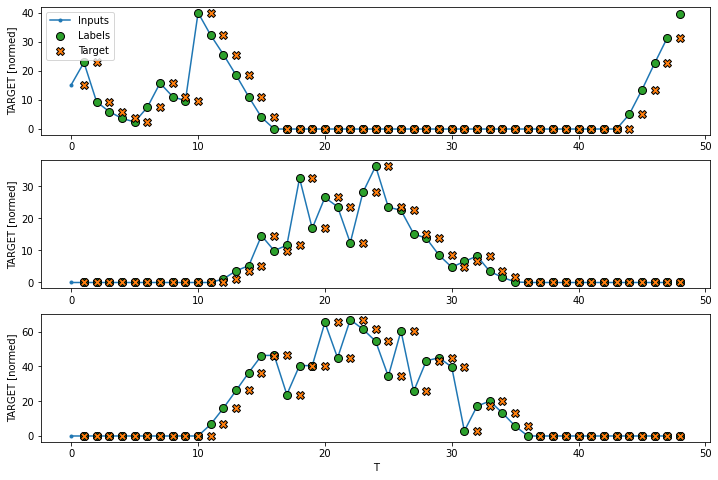

In [17]:
wide_window.plot(baseline)


In [18]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 11)
Output shape: (32, 1, 1)


In [19]:
from src.trainers import compile_and_fit_with_pinball_loss

history = compile_and_fit_with_pinball_loss(
    linear, single_step_window, 0.1
)

val_performance["Linear"] = linear.evaluate(single_step_window.valid)
performance["Linear"] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/1000
1150/1150 [==============================] - 4s 3ms/step - loss: 31.5598 - mean_absolute_error: 89.4326 - mean_squared_error: 12846.2199 - _pinball_loss: 31.5598 - val_loss: 5.9970 - val_mean_absolute_error: 17.6095 - val_mean_squared_error: 471.9585 - val__pinball_loss: 5.9970

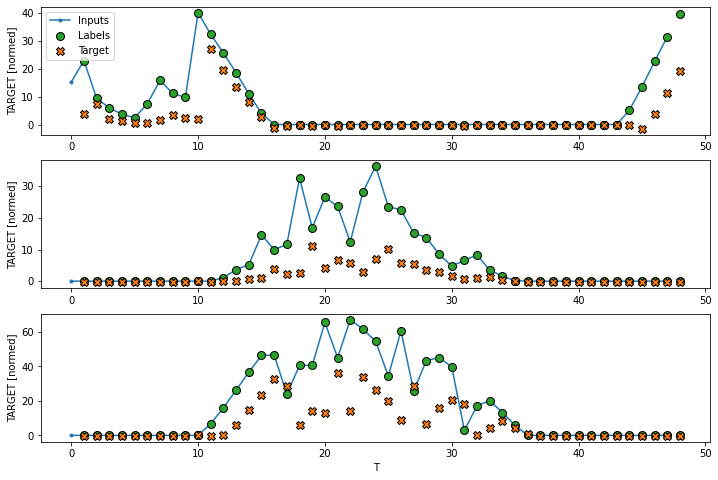

In [20]:
wide_window.plot(linear)


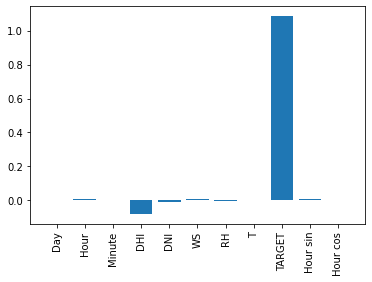

In [21]:
plt.bar(
    x=range(len(train_df.columns)),
    height=linear.layers[0].kernel[:,0].numpy()
)

axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)


In [23]:
from src.model.single.dense import TwoLayerDense

two_layer_dense = TwoLayerDense()
history = compile_and_fit_with_pinball_loss(two_layer_dense, single_step_window, tau=0.1)

val_performance["Dense"] = two_layer_dense.evaluate(single_step_window.valid)
performance["Dense"] = two_layer_dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/1000
1150/1150 [==============================] - 6s 5ms/step - loss: 2.2338 - mean_absolute_error: 14.5663 - mean_squared_error: 733.5856 - _pinball_loss: 2.2338 - val_loss: 1.5930 - val_mean_absolute_error: 13.8629 - val_mean_squared_error: 685.6497 - val__pinball_loss: 1.5930

# 다중 시간 입력
### input: t, t + 1, ..., t + n - 1, output: t + n

In [29]:
CONV_WIDTH = 48
conv_window = WindowGenerator(
    train_df,
    valid_df,
    test_df,
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=["TARGET"],
)
conv_window


            Total window size: 49
            Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
            Label indices: [48]
            Label column name(s): ['TARGET']
        

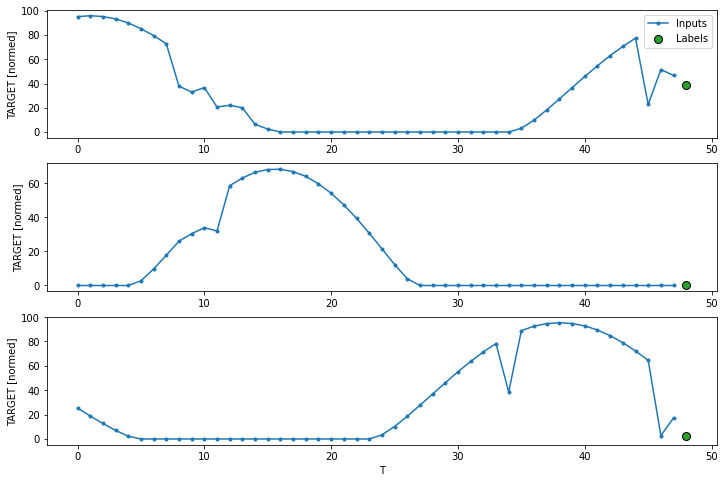

In [30]:
conv_window.plot()
